# Full Source Code
**GT CSE 6250 Spring Project**

Team A1: Brian Popp, bpopp7@gatech.edu, Danielle Velott, dvelott3@gatech.edu

This notebook is a complete rewrite of the original source and provides improvements in order to streamline, modify, and simplify the build process. Full validation and optimization of the original models will be included.

In [1]:
# GT CSE 6250 Spring Project
# Team A1: Brian Popp, bpopp7@gatech.edu, Danielle Velott, dvellot3@gatech.edu
import os
import string
from nltk import word_tokenize
from gensim.models import KeyedVectors, Word2Vec
import numpy as np

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, MaxPool2D
from keras.layers import Conv2D, GlobalAveragePooling1D, MaxPooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC, LinearSVC

## our imports
import pandas as pd
import re
from itertools import chain, repeat, islice
import requests
import matplotlib.pyplot as plt
import io

import nltk
nltk.download('punkt')

## utility functions
def pad_infinite(iterable, padding=None):
   return chain(iterable, repeat(padding))

def pad(iterable, size, padding=None):
   return islice(pad_infinite(iterable, padding), size)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bpopp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
## Using the same variable declarations and configuration options as the original study
ip_txt_file = './data/500_Reddit_users_posts_labels.csv'  # CSV file: "User", "Post", "Label"
ip_feat_file = './data/External_Features.csv'             # CSV file: "User", "Features"
limit_rows = 500   ## used to build a partial dataset

w2v_file = {'file': './out/numberbatch-en-19.08.txt.gz', 
            'is_binary': False, 
            'limit': None, 
            'cache': './out/vectors.kv', 
            'source':'https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz' }

op_file = './out/Result_5-Label_Classification.tsv'
severity_classes = {'Supportive': 0, 'Indicator': 1, 'Ideation': 2, 'Behavior': 3, 'Attempt': 4}

sys_params = {'emb_dim': 300,
              'max_sent_len': 1500,
              'str_padd': '@PADD',
              'cross_val': 5}

cnn_params = {'no_filters': 100,
              'kernels': [3, 4, 5],
              'channel': 1,
              'c_stride': (1, sys_params['emb_dim']),
              'pad': 'same',
              'ip_shape': (sys_params['max_sent_len'], sys_params['emb_dim'], 1),
              'c_activ': 'relu',
              'drop_rate': 0.3,
              'dense_1_unit': 128,
              'dense_2_unit': 128,
              'dense_activ': 'relu',
              'op_unit': 5,             # 5-Label classification
              'op_activ': 'softmax',
              'l_rate': 0.001,
              'loss': 'categorical_crossentropy',
              'batch': 4,
              'epoch': 50,
              'verbose': 1}

intermediate_layer = 'flat_drop'    # for extracting features from CNN

In [3]:
def get_keras_cnn_model():

    input = Input(shape=(sys_params['max_sent_len'], sys_params['emb_dim'], 1), dtype='float32')
    
    conv_layers = []
    for filter in cnn_params['kernels']:
        conv2d = Conv2D(filters=cnn_params['no_filters'], kernel_size=(filter, sys_params['emb_dim']), strides=cnn_params['c_stride'],
                        padding=cnn_params['pad'], data_format='channels_last', input_shape=cnn_params['ip_shape'],
                        activation=cnn_params['c_activ'])(input)
        l_pool = MaxPool2D(pool_size=(sys_params['max_sent_len'], 1))(conv2d)
        conv_layers.append(l_pool)
        
    l_concat = Concatenate(axis=1)(conv_layers)
    l_flat = Flatten()(l_concat)
    l_drop = Dropout(rate=cnn_params['drop_rate'], name='flat_drop')(l_flat)
    output = Dense(units=cnn_params['op_unit'], activation=cnn_params['op_activ'], name='cnn_op')(l_drop)
    
    final_model = Model(input, output)
    final_model.compile(optimizer=Adam(learning_rate=cnn_params['l_rate']), loss=cnn_params['loss'], metrics=['accuracy'])   
    
    return final_model

## using the same validation function as the original study (see presentation)
def get_prf1_score(y_true, y_pred):
    tp, fp, fn = 0.0, 0.0, 0.0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            tp += 1
        elif y_pred[i] > y_true[i]:
            fp += 1
        else:
            fn += 1
    if tp == 0:
        tp = 1.0
    if fp == 0:
        fp = 1.0
    if fn == 0:
        fn  = 1.0
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F = 2 * P * R / (P + R)
    return P, R, F

def get_confusion_matrix ( y_true, y_pred, labels = ['SU','IN','ID','BR','AT'], ax=None ):
    if ax is None:
        fig, ax = plt.subplots ( figsize=(5,4) )
    
    font = {'family' : 'Sans',
        'weight' : 'normal',
        'size'   : 18}
    plt.rc('font', **font)
    
    ConfusionMatrixDisplay.from_predictions( y_true, y_pred, display_labels=labels, ax=ax, cmap=plt.cm.Blues, colorbar=False );
    ax.set_xlabel ( '' );
    ax.set_ylabel ( '' );
    ax.tick_params(axis='x', labelrotation=45);
    ax.spines['bottom'].set_color(None);
    ax.spines['top'].set_color(None);
    ax.spines['right'].set_color(None);
    ax.spines['left'].set_color(None);

    return ax;

# get_confusion_matrix ( y_true, y_pred );

## Primary Dataset
The study's primary dataset is 500 rows of de-identified social media posts discussing various aspects of self-destructive behavior. Each row has a user id, the text of the post, and a label describing how the post was manually classified.      

In [4]:
df = pd.read_csv ( ip_txt_file ).loc[:limit_rows]

# display ( df.groupby('Label').sample(1)[::-1] )
print ( f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Rows: 500, Columns: 3


## Cleanup
The original study provided code to do the word tokenization, but it was based on an older version of python and honestly wasn't very efficient. We've cleaned this up a bit by converting to pandas and using more pythonic transformations. 

In [5]:
df['post_clean'] = df.Post.str.lower() # convert to lowercase
df['post_clean'] = df.post_clean.str.replace("/[^ -~]+/g","", regex=True) ## remove non-printable
df["post_clean"] = df.post_clean.str.replace('[^\w\s]','', regex=True) ## remove punctuation
df["post_clean"] = df.post_clean.apply(word_tokenize) ## tokenize
df["post_clean"] = df.post_clean[:sys_params['max_sent_len']] # limit length
df["post_clean"] = df.post_clean.apply ( lambda x : list(pad(x, sys_params['max_sent_len'], sys_params['str_padd']))) ## pad list

df['LabelCode'] = df.Label.map ( severity_classes ) ## map labels to codes

labels = np.array (df.LabelCode.values)
print ( 'labels:', labels[:5] )

posts = np.array(df.post_clean.values.tolist())
print ( 'posts: ', posts[:5] )

labels: [0 2 3 4 2]
posts:  [['its' 'not' 'a' ... '@PADD' '@PADD' '@PADD']
 ['it' 'can' 'be' ... 'my' 'studies' 'and']
 ['hi' 'so' 'last' ... '@PADD' '@PADD' '@PADD']
 ['i' 'tried' 'to' ... '@PADD' '@PADD' '@PADD']
 ['hi' 'nem3030' 'what' ... '@PADD' '@PADD' '@PADD']]


In [101]:
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 5)
pd.DataFrame ( posts )

,0,1,2,3,4,5,6,...,1493,1494,1495,1496,1497,1498,1499
0,its,not,a,viable,option,and,youll,...,@PADD,@PADD,@PADD,@PADD,@PADD,@PADD,@PADD
1,it,can,be,hard,to,appreciate,the,...,am,progressing,well,in,my,studies,and
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,dont,know,there,as,dumb,as,it,...,@PADD,@PADD,@PADD,@PADD,@PADD,@PADD,@PADD
499,gtit,gets,better,trust,meive,spent,long,...,@PADD,@PADD,@PADD,@PADD,@PADD,@PADD,@PADD


In [7]:
df.LabelCode.values

array([0, 2, 3, 4, 2, 0, 0, 2, 0, 2, 1, 0, 3, 2, 2, 3, 2, 3, 4, 2, 0, 2,
       2, 0, 4, 4, 1, 2, 2, 0, 4, 0, 2, 3, 3, 2, 2, 1, 2, 0, 0, 3, 2, 4,
       2, 2, 4, 2, 4, 0, 0, 2, 2, 1, 2, 0, 3, 2, 2, 3, 2, 4, 2, 0, 1, 3,
       3, 3, 1, 2, 3, 0, 0, 2, 1, 3, 0, 3, 1, 2, 0, 2, 4, 2, 3, 0, 0, 4,
       2, 1, 3, 3, 3, 2, 2, 3, 3, 4, 3, 2, 2, 3, 2, 0, 1, 3, 2, 3, 2, 3,
       4, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 3, 4, 2, 2, 2, 1, 2, 2, 3,
       0, 3, 3, 2, 3, 1, 0, 2, 0, 2, 4, 2, 3, 1, 1, 4, 3, 1, 0, 1, 1, 2,
       1, 1, 3, 0, 2, 1, 2, 2, 0, 0, 1, 0, 4, 0, 2, 0, 1, 1, 2, 2, 3, 1,
       3, 2, 2, 2, 2, 2, 3, 0, 2, 1, 1, 3, 2, 1, 2, 0, 4, 0, 1, 3, 3, 1,
       0, 2, 3, 2, 0, 3, 2, 3, 0, 3, 0, 0, 3, 1, 2, 2, 1, 2, 2, 2, 4, 2,
       2, 3, 2, 3, 3, 0, 2, 2, 1, 1, 0, 0, 3, 1, 2, 1, 0, 4, 4, 1, 2, 1,
       2, 0, 0, 2, 2, 1, 2, 0, 2, 3, 2, 1, 4, 1, 3, 2, 1, 2, 0, 3, 0, 0,
       1, 1, 1, 3, 1, 0, 1, 4, 2, 2, 4, 4, 2, 2, 3, 1, 1, 3, 3, 1, 2, 2,
       3, 1, 1, 2, 0, 2, 4, 2, 1, 0, 0, 4, 2, 1, 2,

## Vectorize
Features are built by mapping word tokens to vectors of similar words. These similarities are taken from pre-built
similarity vectors. For this study, the authors used a popular open-source project called ConceptNet. From their documentation:

> ConceptNet is a freely-available semantic network, designed to help computers 
> understand the meanings of words that people use.

We've improved on the study's code by allowing these vectors to be automatically downloaded and by caching word 
vectors to significantly reduce loading time.

In [8]:
if (w2v_file['cache'] != "") & (os.path.isfile ( w2v_file['cache']) ):
    print ( "Using cached vectors." )
    w2v_model = KeyedVectors.load(w2v_file['cache'])
else:
    if not os.path.isfile ( w2v_file['file'] ):
        print ( f"Could not find {w2v_file['file']}.. attempting download from {w2v_file['source']}." )
        r = requests.get(w2v_file['source'], allow_redirects=True)
        open ( w2v_file['file'], 'wb').write ( r.content )
    
    print ( "Loading vectors... this will take a few minutes.." )
    w2v_model = KeyedVectors.load_word2vec_format(w2v_file['file'], binary=w2v_file['is_binary'], limit=w2v_file['limit'])
    if w2v_file['cache'] != "":
        w2v_model.save( w2v_file['cache'] )

w2v_model


Using cached vectors.


## Sample of a ConceptNet Word Vector

In [96]:
embeddingdf = pd.DataFrame ( columns=['Pos','Word', 'Embedding'] )
for word in ['viable','appreciate','sitting']:
    tempdf = pd.DataFrame ( columns=embeddingdf.columns )
    tempdf['Pos'] = range(300)
    tempdf['Embedding'] = w2v_model[word]
    tempdf['Word'] = word
    embeddingdf = pd.concat ( [embeddingdf ,tempdf] ) if len(embeddingdf) else tempdf
    
embeddingdf = embeddingdf.pivot_table ( index='Word',columns='Pos', aggfunc='first', values='Embedding')
embeddingdf

# word1 = pd.DataFrame( w2v_model['viable'] )
# word1['id'] = range(len(word1))
# word1['Word'] = 'viable'
# 
# word2 = pd.DataFrame(w2v_model['appreciation'])             
# word2['id'] = range(len(word2))
# word2['Word'] = 'appreciation'
# 
# vectordf = pd.concat ( [ word1, word2 ] )
# display (vectordf)
# vectordf.columns = ['embedding']
# vectordf.pivot_table ( index='Word', columns='id', aggfunc='first', values='embedding')

Pos,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Word,,,,,,,,,,,,,,,,,,,,,
appreciate,-0.1502,-0.1842,-0.0622,-0.0213,0.0621,0.0628,0.1369,-0.0453,0.2151,-0.1233,...,0.0247,0.0230,-0.0164,0.0060,0.0566,0.0092,0.0334,0.0444,0.0195,-0.0213
sitting,-0.0589,-0.1078,0.0863,0.0834,-0.0365,0.0042,-0.0394,-0.0217,0.0835,0.0725,...,-0.0417,0.0172,0.0023,0.0262,-0.0722,-0.0547,-0.0107,-0.0114,-0.0506,-0.0188
viable,-0.1187,0.0032,-0.1273,0.0401,0.0483,0.0687,0.0207,0.1111,0.1148,-0.1166,...,0.0027,-0.0087,0.0384,0.0126,-0.0873,-0.0594,0.0028,0.0339,-0.0376,-0.0201


In [102]:
vocab = w2v_model.key_to_index
padding = np.zeros(sys_params['emb_dim'], dtype='float32')

vectors = []
for sentence in posts:
    vector = []
    for tok in sentence:
        if tok==sys_params['str_padd']:
            vector.append(list(padding))
        
        elif tok in vocab:
            vector.append(w2v_model[tok].astype(float).tolist())
    
        else:
            vector.append(list(padding))
    
    vectors.append(vector)   
    
x_data, y_data = np.array(vectors), np.array ( labels )
print ( x_data.shape, y_data.shape )


(500, 1500, 300) (500,)


In [108]:
pd.DataFrame ( x_data.reshape(500,300*1500) )

,0,1,2,3,4,5,6,...,449993,449994,449995,449996,449997,449998,449999
0,-0.0863,-0.0878,-0.0425,0.0321,-0.0503,-0.0198,0.0787,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.1443,-0.1320,0.0170,0.0389,0.0335,0.0039,0.0745,...,-0.1133,-0.0726,0.0659,-0.0282,-0.0354,0.0252,0.0449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,-0.0994,-0.0509,-0.0007,-0.0728,0.0089,0.0095,-0.0718,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
499,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## Save the Dataset

In [10]:
x_data_all = x_data.reshape(x_data.shape[0], x_data.shape[1], x_data.shape[2], 1)
y_data_all = labels

np.savez_compressed ( f'./data/fulldataset.npz', x=x_data_all, y=y_data_all )

## Load the Dataset

In [20]:
dataset = np.load ( './data/fulldataset.npz' )
x_data_all = dataset['x']
y_data_all = dataset['y']
y_data_df = pd.DataFrame ( dataset['y'] )
print ( x_data_all.shape, y_data_all.shape )

(500, 1500, 300, 1) (500,)


## Show the Model

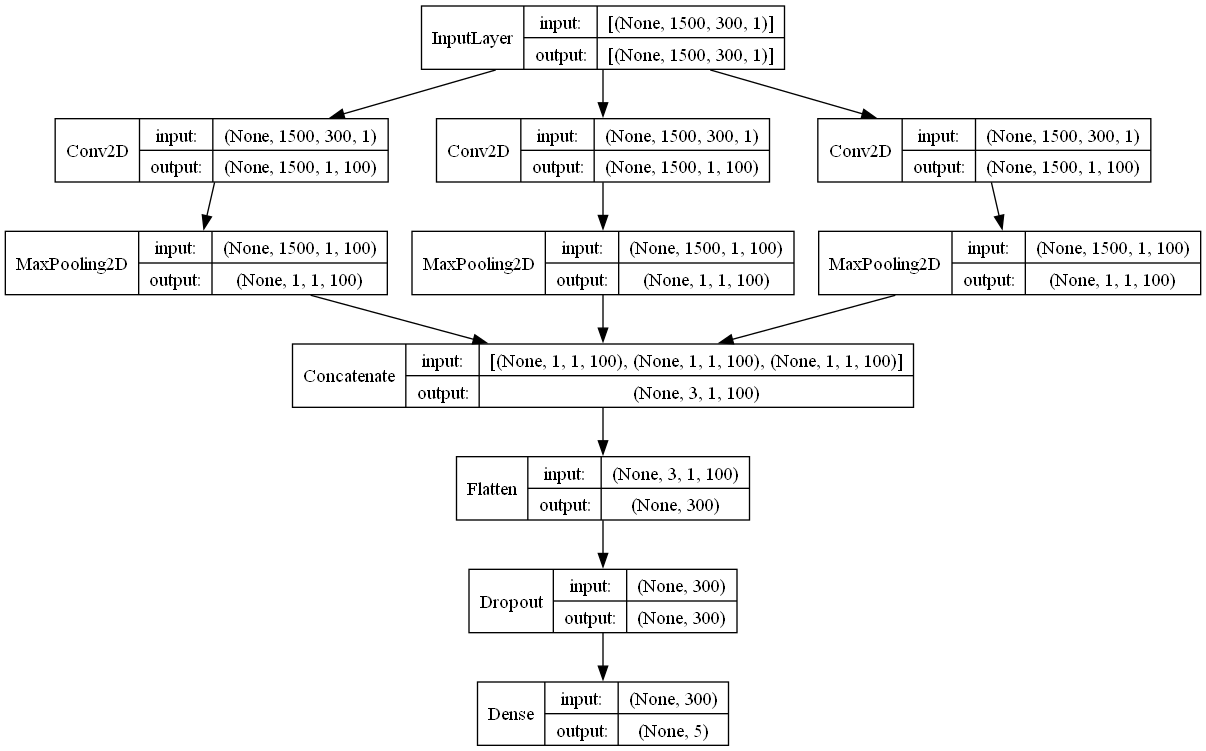

In [12]:
model = get_keras_cnn_model()
from keras.utils import plot_model
plot_model(model, to_file='images/5category_cnn_model.png', show_shapes=True, show_layer_names=False)


## Run the Model (simple)

train: (400, 1500, 300, 1) (400, 1)
test: (100, 1500, 300, 1) (100, 1)
4/4 [==============================] - 1s 205ms/step


,Precision,Recall,F1-Score
Model,,,
CNN,0.466,0.557,0.507


<Axes: >

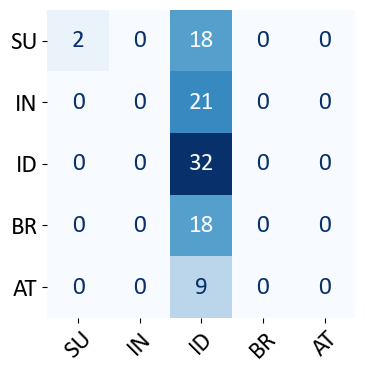

In [38]:
x_train, x_test, y_train, y_test = train_test_split( x_data_all , y_data_df, test_size=0.20)
print ( 'train:', x_train.shape, y_train.shape )
print ( 'test:', x_test.shape, y_test.shape )

epochs = 2 #cnn_params['epoch']
cnn_model = get_keras_cnn_model()
cnn_model.fit(x=x_train, y=to_categorical(y_train), batch_size=4, epochs=epochs, verbose=0)

y_pred = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1) ## find the classifier with the highest probability
y_true = y_test.values

precision, recall, f1 = get_prf1_score(y_true, y_pred)
result_df.loc['CNN'] = pd.Series({'Precision': round(precision, 3),
                                  'Recall': round(recall, 3),
                                  'F1-Score': round(f1, 3)})
display(result_df.loc[['CNN']])

get_confusion_matrix ( y_true, y_pred )


## Run the Model (KFold Cross Validation)

In [172]:
result_df = pd.DataFrame( columns=['Model', 'Precision','Recall','F1-Score'] ).set_index ( 'Model' )

epochs=50
scores = []

skf = StratifiedKFold(n_splits=sys_params['cross_val'])
skf.get_n_splits(x_data_all, y_data_all)


for cv_count, (train_index, test_index) in enumerate(skf.split(x_data_all, y_data_all), start=1):
    print ('\nRunning Stratified Cross Validation: {0}/{1}...'.format(cv_count, sys_params['cross_val']))

    x_train, x_test = x_data_all[train_index], x_data_all[test_index]
    y_train, y_test = y_data_all[train_index], y_data_all[test_index]

    cnn_model = get_keras_cnn_model()
    cnn_model.fit(x=x_train, y=to_categorical(y_train), batch_size=4, epochs=epochs, verbose=0)
    
    y_pred = cnn_model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = y_test

    precision, recall, f1 = get_prf1_score(y_true, y_pred)
    print ('\nPrecision: {0}\t Recall: {1}\t F1-Score: {2}'\
        .format(round(precision,3), round(recall,3), round(f1,3)))

    scores.append({'I':cv_count, 'Precision':precision, 'Recall':recall, 'F1-Score':f1})

sumdf = pd.DataFrame ( scores ).set_index('I')
result_df.loc['CNN K-Fold'] = sumdf.mean()
sumdf.loc['Average'] = sumdf.mean()

display ( sumdf )


Running Stratified Cross Validation: 1/5...
4/4 [==============================] - 1s 217ms/step

Precision: 0.726	 Recall: 0.542	 F1-Score: 0.621

Running Stratified Cross Validation: 2/5...
4/4 [==============================] - 1s 225ms/step

Precision: 0.667	 Recall: 0.532	 F1-Score: 0.592

Running Stratified Cross Validation: 3/5...
4/4 [==============================] - 1s 233ms/step

Precision: 0.667	 Recall: 0.532	 F1-Score: 0.592

Running Stratified Cross Validation: 4/5...
4/4 [==============================] - 1s 218ms/step

Precision: 0.7	 Recall: 0.512	 F1-Score: 0.592

Running Stratified Cross Validation: 5/5...
4/4 [==============================] - 1s 202ms/step

Precision: 0.565	 Recall: 0.557	 F1-Score: 0.561


,Precision,Recall,F1-Score
I,,,
1,0.725806,0.542169,0.620690
2,0.666667,0.531646,0.591549
...,...,...,...
5,0.565217,0.557143,0.561151
Average,0.664871,0.534960,0.591298


## SVM Models

,Precision,Recall,F1-Score
Model,,,
SVM-RBF,0.493,0.547,0.519


<Axes: >

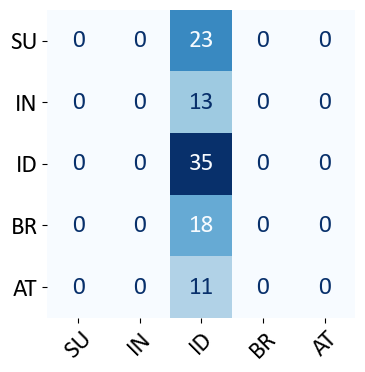

In [173]:
x_train, x_test, y_train, y_test = train_test_split( x_data_all , y_data_df, test_size=0.20)

# SVM-Radial Basis Function (RBF): for comparison
n_users, x, y, z = x_train.shape
x_train_svm = x_train.reshape((n_users, x*y*z))
n_users, x, y, z = x_test.shape
x_test_svm = x_test.reshape((n_users, x*y*z))

rbf_model = SVC(kernel='rbf', gamma=0.1, decision_function_shape='ovr')
rbf_model.fit(x_train_svm, y_train.values.ravel())

y_pred = rbf_model.predict(x_test_svm)
y_true = y_test.values


precision, recall, f1 = get_prf1_score(y_true, y_pred)
result_df.loc['SVM-RBF'] = pd.Series({'Precision': round(precision, 3),
                                      'Recall': round(recall, 3),
                                      'F1-Score': round(f1, 3)})
display(result_df.loc[['SVM-RBF']])

get_confusion_matrix ( y_true, y_pred )

,Precision,Recall,F1-Score
Model,,,
SVM-L,0.458,0.397,0.425


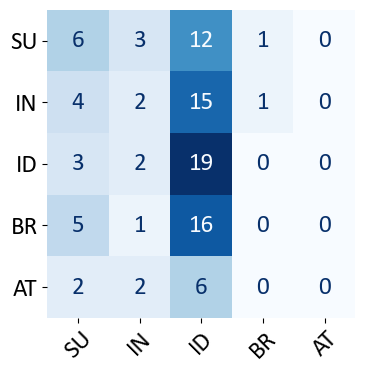

In [174]:
x_train, x_test, y_train, y_test = train_test_split( x_data_all , y_data_df, test_size=0.20)

# Linear SVM-L: for comparison
l_model = LinearSVC( dual='auto' )
l_model.fit(x_train_svm, y_train.values.ravel())

y_pred = l_model.predict(x_test_svm)
y_true = y_test.values

precision, recall, f1 = get_prf1_score(y_true, y_pred)
result_df.loc['SVM-L'] = pd.Series ( {'Precision':round(precision,3), 
                                   'Recall':round(recall,3), 
                                   'F1-Score':round(f1,3)} )
display(result_df.loc[['SVM-L']])

get_confusion_matrix ( y_true, y_pred );



## Evaluation Results

In [184]:
result_df.round(3)

,Precision,Recall,F1-Score
Model,,,
CNN K-Fold,0.665,0.535,0.591
SVM-RBF,0.493,0.547,0.519
SVM-L,0.458,0.397,0.425


## Experimentation
### Loss and Accuracy

In [2]:
x_train, x_test, y_train, y_test = train_test_split( x_data_all , y_data_df, test_size=0.20)
print ( 'train:', x_train.shape, y_train.shape )
print ( 'test:', x_test.shape, y_test.shape )

NameError: name 'train_test_split' is not defined

train: (400, 1500, 300, 1) (400, 1)
test: (100, 1500, 300, 1) (100, 1)
4/4 [==============================] - 1s 211ms/step


,Precision,Recall,F1-Score
Model,,,
CNN-Paper,0.721,0.53,0.611


<Axes: >

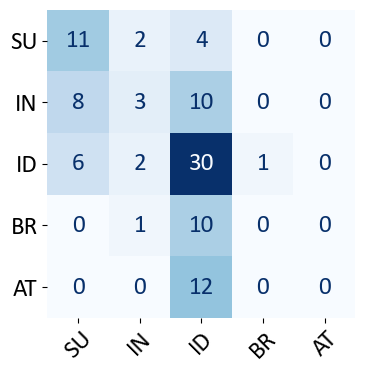

In [164]:
testing_df = pd.DataFrame( columns=['Model', 'Precision','Recall','F1-Score'] ).set_index ( 'Model' )

x_train, x_test, y_train, y_test = train_test_split( x_data_all , y_data_df, test_size=0.20)
print ( 'train:', x_train.shape, y_train.shape )
print ( 'test:', x_test.shape, y_test.shape )

epochs = 50 #cnn_params['epoch']
cnn_model = get_keras_cnn_model()
history = cnn_model.fit(x=x_train, y=to_categorical(y_train), batch_size=4, epochs=epochs, verbose=0)

y_pred_cat = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred_cat, axis=-1) ## find the classifier with the highest probability
y_true = y_test.values

precision, recall, f1 = get_prf1_score(y_true, y_pred)
testing_df.loc['CNN-Paper'] = pd.Series({'Precision': round(precision, 3),
                                  'Recall': round(recall, 3),
                                  'F1-Score': round(f1, 3)})
display(testing_df.loc[['CNN-Paper']])

get_confusion_matrix ( y_true, y_pred )

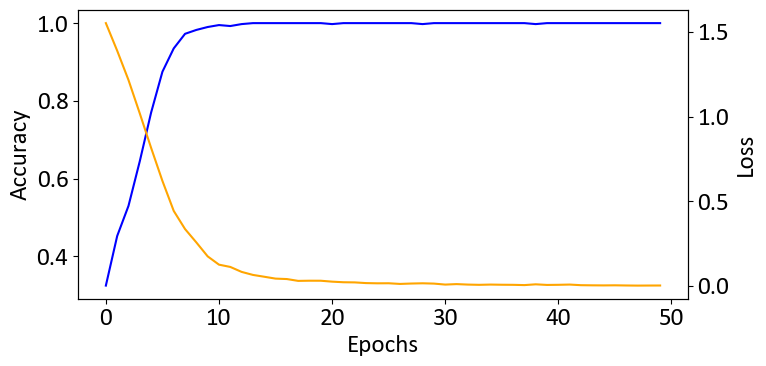

In [171]:
fig, ax = plt.subplots ( nrows=1, figsize=(8,4), sharex=True )
ax.plot(history.history['accuracy'], 'b-' )
# ax.plot(history.history['loss'])
ax.set_ylabel('Accuracy')
ax2 = ax.twinx()
ax2.plot(history.history['loss'], color='orange' )
ax2.set_ylabel('Loss')


ax.set_xlabel('Epochs')
# summarize history for loss

plt.tight_layout()
plt.show()


### Filters

In [61]:
testing_df = pd.DataFrame( columns=['Model', 'Precision','Recall','F1-Score'] ).set_index ( 'Model' )
filter_groups = {'[3,4,5] (paper)':[3,4,5], '[3,5,7]':[3,5,7], '[5,7,10]':[5,7,10], '3':[3], '5':[5], '7':[7], '10':[10] }

epochs = 5
input_shape = (1500,300,1)
for experiment, filters in filter_groups.items():
    input = Input(shape=input_shape, dtype='float32')
    conv_layers = []
    for filter in filters:
        conv2d = Conv2D(filters=100, kernel_size=(filter, 300), strides=(1, 300),
                        padding='same', data_format='channels_last', input_shape=input_shape,
                        activation='relu')(input)
        conv_layers.append ( MaxPool2D(pool_size=(1500, 1))(conv2d) )
    
    l_concat = Concatenate(axis=1)(conv_layers)
    l_flat = Flatten()(l_concat)
    l_drop = Dropout(rate=0.3, name='flat_drop')(l_flat)
    output = Dense(units=5, activation='softmax', name='cnn_op')(l_drop)
    
    m = Model(input, output)
    m.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = m.fit(x=x_train, y=to_categorical(y_train), batch_size=4, epochs=epochs, verbose=1)
    
    y_pred = m.predict(x_test)
    y_pred = np.argmax(y_pred, axis=-1) ## find the predicted classifier with the highest probability
    y_true = y_test.values ## convert back to numpy
    
    precision, recall, f1 = get_prf1_score(y_true, y_pred)
    testing_df.loc[experiment] = pd.Series({'Precision': round(precision, 3),
                                      'Recall': round(recall, 3),
                                      'F1-Score': round(f1, 3)})

display(testing_df)

Epoch 1/5
100/100 [==============================] - 15s 132ms/step - loss: 1.5726 - accuracy: 0.3050
Epoch 2/5
100/100 [==============================] - 13s 133ms/step - loss: 1.4444 - accuracy: 0.4050
Epoch 3/5
100/100 [==============================] - 13s 133ms/step - loss: 1.2591 - accuracy: 0.5250
Epoch 4/5
100/100 [==============================] - 13s 132ms/step - loss: 1.0871 - accuracy: 0.6000
Epoch 5/5
4/4 [==============================] - 1s 204ms/step
Epoch 1/5
100/100 [==============================] - 18s 171ms/step - loss: 1.5691 - accuracy: 0.3225
Epoch 2/5
100/100 [==============================] - 17s 172ms/step - loss: 1.3732 - accuracy: 0.4300
Epoch 3/5
100/100 [==============================] - 17s 172ms/step - loss: 1.1789 - accuracy: 0.5775
Epoch 4/5
100/100 [==============================] - 17s 173ms/step - loss: 0.9231 - accuracy: 0.7100
Epoch 5/5
4/4 [==============================] - 1s 255ms/step
Epoch 1/5
100/100 [==============================] - 25s 2

,Precision,Recall,F1-Score
Model,,,
"[3,4,5] (paper)",0.706,0.424,0.529
"[3,5,7]",0.701,0.588,0.639
"[5,7,10]",0.532,0.667,0.592
3,0.745,0.437,0.551
5,0.506,0.629,0.561
7,0.500,0.613,0.551
10,0.811,0.478,0.601


In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']